# Tool-Augmented LLM

## 개요

### 아키텍처

```
사용자 질문 입력
    -> SQL 생성
    -> DB SQL 실행 (도구 호출)
    -> 결과물 사용자에게 응답.
```

### 구현 내용
- DB 스키마 (4개 테이블로 이루어진 캐글 데이터)
- SQL 전문가 페르소나
- 각 테이블 레코드 일부
- 단일 LLM 호출

## 코드 구현

In [1]:
from langchain.chat_models import init_chat_model
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_core.messages import (
    AIMessage,
)

from langgraph.graph import StateGraph, END, START, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import InMemorySaver

from sqlalchemy import create_engine
from IPython.display import display, Image
from typing import Literal

import pandas as pd

### Initialize Database

In [2]:
def setup_database(db_path: str = "sqlite:///data/mydb.db") -> SQLDatabase:
    """Initialize SQL database connection."""
    engine = create_engine(db_path)
    db = SQLDatabase(engine)
    return db

# Global instances
db = setup_database()

print(f"Dialect: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")

Dialect: sqlite
Available tables: ['cards', 'customers', 'merchant_category', 'transactions']


In [3]:
print("=== cards Table Schema ===")
display(pd.read_sql_query("SELECT * FROM cards LIMIT 3", db._engine))
print("=== customers Table Schema ===")
display(pd.read_sql_query("SELECT * FROM customers LIMIT 3", db._engine))
print("=== merchant_category Table Schema ===")
display(pd.read_sql_query("SELECT * FROM merchant_category LIMIT 3", db._engine))
print("=== transactions Table Schema ===")
display(pd.read_sql_query("SELECT * FROM transactions LIMIT 3", db._engine))


=== cards Table Schema ===


,account_id,customer_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit_usd,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,2022-12-01,623,YES,2,24295.0,2002-09-01,2008,No
1,2731,825,Visa,Debit,4956965974959986,2020-12-01,393,YES,2,21968.0,2014-04-01,2014,No
2,3701,825,Visa,Debit,4582313478255491,2024-02-01,719,YES,2,46414.0,2003-07-01,2004,No


=== customers Table Schema ===


,customer_id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income_usd,yearly_income_usd,total_debt_usd,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,37891.0,77254.0,191349.0,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,22681.0,33483.0,196.0,698,5


=== merchant_category Table Schema ===


,merchant_category_code,merchant_description
0,5812,Eating Places and Restaurants
1,5541,Service Stations
2,7996,"Amusement Parks, Carnivals, Circuses"


=== transactions Table Schema ===


,id,date,client_id,card_id,amount_usd,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,None
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,None
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,None


### Initialize Model

In [4]:
def setup_llm(model: str = "gpt-4.1-mini", temperature: float = 0):
    """Initialize LLM for the agent."""
    llm = init_chat_model(
        model=model, model_provider="openai", temperature=temperature
    )
    return llm

# Global instances
llm = setup_llm()

### Nodes & Tools

In [5]:
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

run_query_tool = next(tool for tool in tools if tool.name=="sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query_tool")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



In [6]:
def inject_db_info(state: MessagesState):
    all_tables = db.get_usable_table_names()
    schema_info = db.get_table_info()  # 전체 스키마

    db_context = f"""<database_info>
<tables>{", ".join(all_tables)}</tables>
<schema>
{schema_info}
</schema>
</database_info>"""

    return {"messages": [AIMessage(content=db_context)]}


def generate_query(state: MessagesState):

    generate_query_system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
""".format(
        dialect=db.dialect,
        top_k=5,
    )

    system_message = {
        "role": "system",
        "content": generate_query_system_prompt,
    }
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    run_query_tool = next(tool for tool in tools if tool.name == "sql_db_query")
    llm_with_tools = llm.bind_tools([run_query_tool])
    response = llm_with_tools.invoke([system_message] + state["messages"])

    return {"messages": [response]}

### Build LangGraph

In [7]:
def should_continue(state: MessagesState) -> Literal[END, "run_query"]:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    else:
        return "run_query"


def create_sql_agent_graph():
    """
    Create the LangGraph workflow for SQL agent.
    
    Workflow:
        START → generate_sql → execute_query → generate_answer → END

    기획한 아키텍처:
        사용자 질문 입력 -> SQL 생성 -> DB SQL 실행 -> 결과물 사용자에게 응답.
    """

    # Create graph
    builder = StateGraph(MessagesState)

    # Add nodes
    builder.add_node("inject_db_info", inject_db_info)
    builder.add_node("generate_query", generate_query)
    builder.add_node("run_query", run_query_node)

    # Add Edges
    builder.add_edge(START, "inject_db_info")
    builder.add_edge("inject_db_info", "generate_query")
    builder.add_conditional_edges(
        "generate_query",
        should_continue,
    )
    builder.add_edge("run_query", "generate_query")
    builder.add_edge("generate_query", END)

    # Compile
    checkpointer = InMemorySaver() 
    agent = builder.compile(checkpointer=checkpointer)

    return agent

In [8]:
agent = create_sql_agent_graph()

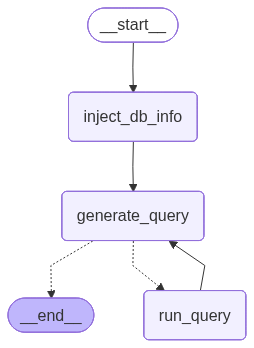

In [9]:
display(Image(agent.get_graph().draw_mermaid_png()))

## Test

In [43]:
import json

config = {"configurable": {"thread_id": "1"}}

test_questions = [
    "transactions 테이블에 레코드가 몇 개 있나요?",
    "2015년에 가장 높은 지출이 있었던 카테고리는 무엇인가요? SQL 쿼리도 함께 보여주세요.",
    "2016년 한 해 동안 총 지출 금액은 얼마인가요?",
]

for question in test_questions:
    for step in agent.stream(
        {"messages": [{"role": "user", "content": question}]},
        config,
        stream_mode="values",
    ):
        if "messages" in step:
            step["messages"][-1].pretty_print()
        elif "__interrupt__" in step:
            action = step["__interrupt__"][0]
            print("INTERRUPTED:")
            for request in action.value:
                print(json.dumps(request, indent=2))
        else:
            pass
    print('---')

================================ Human Message =================================

transactions 테이블에 레코드가 몇 개 있나요?
================================== Ai Message ==================================

<database_info>
<tables>cards, customers, merchant_category, transactions</tables>
<schema>

CREATE TABLE cards (
	account_id BIGINT, 
	customer_id BIGINT, 
	card_brand TEXT, 
	card_type TEXT, 
	card_number BIGINT, 
	expires TEXT, 
	cvv BIGINT, 
	has_chip TEXT, 
	num_cards_issued BIGINT, 
	credit_limit_usd FLOAT, 
	acct_open_date TEXT, 
	year_pin_last_changed BIGINT, 
	card_on_dark_web TEXT
)

/*
3 rows from cards table:
account_id	customer_id	card_brand	card_type	card_number	expires	cvv	has_chip	num_cards_issued	credit_limit_usd	acct_open_date	year_pin_last_changed	card_on_dark_web
4524	825	Visa	Debit	4344676511950444	2022-12-01	623	YES	2	24295.0	2002-09-01	2008	No
2731	825	Visa	Debit	4956965974959986	2020-12-01	393	YES	2	21968.0	2014-04-01	2014	No
3701	825	Visa	Debit	4582313478255491	2024-02